In [1]:
import galprime as gp

import numpy as np

from matplotlib import pyplot as plt

from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from astropy.modeling.models import Gaussian2D

from tqdm import tqdm

In [2]:
bd_table = Table.read("../pdata/Simard_BD_Table_pix.fits")

print(len(bd_table), bd_table.colnames)

config = gp.read_config_file("disk_bulge.gprime")

backgrounds = gp.Cutouts.from_file("../pdata/cutouts_i.fits")

672071 ['objID', 'z', 'Sp', 'Scale', 'Vmax', 'gg2d', 'e_gg2d', 'rg2d', 'e_rg2d', '__B_T_g', '__B_T_r', 'Re', 'e_Re', 'ellip_b', 'phib', 'Rd', 'e_Rd', 'i', 'e_i', 'phid', 'e_phid', 'ggMag', 'rgMag', 'nb', '_RA', '_DE', 'ellip_d']


In [3]:
keys = config["KEYS"].values()
keys.extend(config["BINS"].keys())
print(keys)

['gg2d', '__B_T_g', 'Rd', 'nb', 'Re', 'ellip_d', 'ellip_b', 'z']


In [4]:
bd_table_trimmed = gp.check_and_remove_masked(bd_table)
binlist = gp.bin_catalogue(bd_table_trimmed, 
                           bin_params=config["BINS"], 
                           params=config["KEYS"])

{'MAG': 18.364418373414836, 'FBULGE': 0.9113010990905112, 'REFF_BULGE': 22.720107597260494, 'N_BULGE': 5.528979460546102, 'REFF_DISK': 10.776359824326903, 'ELLIP_DISK': 0.19696909624440262, 'ELLIP_BULGE': 0.1736262587759262, 'SHAPE': 451, 'M0': 27.0, 'PA': 0.5375986677766686, 'BULGE_MAG': 18.46526363825931, 'BULGE_M0': 27.0, 'BULGE_REFF': 22.720107597260494, 'BULGE_N': 5.528979460546102, 'BULGE_ELLIP': 0.1736262587759262, 'BULGE_PA': 0.5375986677766686, 'BULGE_X0': 225.5, 'BULGE_Y0': 225.5, 'BULGE_SHAPE': (451, 451), 'DISK_MAG': 20.994622777384038, 'DISK_M0': 27.0, 'DISK_REFF': 10.776359824326903, 'DISK_N': 1.0, 'DISK_ELLIP': 0.19696909624440262, 'DISK_PA': 0.5375986677766686, 'DISK_X0': 225.5, 'DISK_Y0': 225.5, 'DISK_SHAPE': (451, 451)}


<ipython-input-5-f32bd8051c50>:18: RuntimeWarning: invalid value encountered in log10
  im2 = ax[1].imshow(np.log10(z + bg), origin="lower", vmin=-3, vmax=1)


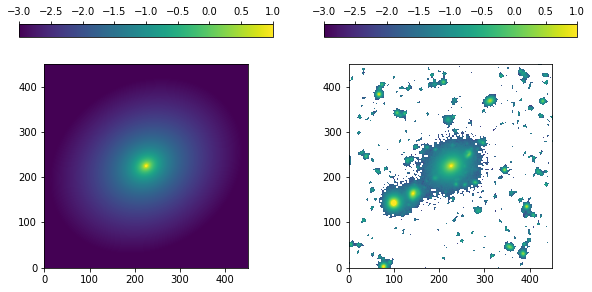

In [5]:

b = binlist.bins[0]
model_template = gp.BulgeDiskSersicModel()
keys, kde = gp.setup_kde(model_template, config, b.objects)

params = gp.sample_kde(config, keys, kde, model=model_template)
params = gp.update_required(params, config)

z, z_params = model_template.generate(params)

print(z_params)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), facecolor="white")

im1 = ax[0].imshow(np.log10(z), origin="lower", vmin=-3, vmax=1)

bg = backgrounds.cutouts[0]

im2 = ax[1].imshow(np.log10(z + bg), origin="lower", vmin=-3, vmax=1)

plt.colorbar(im1, ax=ax[0], location="top", pad=0.1)
plt.colorbar(im2, ax=ax[1], location="top", pad=0.1)

In [6]:
def gen_gaussian(**kwargs):
    """
    Generate a single Sersic model.
    Args:
        **kwargs: Arbitrary keyword arguments representing model parameters.
            - "MAG" (int): Magnitude of the galaxy, default is 22.
            - "REFF" (int): Effective radius of the galaxy, default is 1.
            - "N" (int): Sersic index, default is 1.
            - "ELLIP" (float): Ellipticity of the galaxy, default is 0.3.
            - "PA" (float): Position angle of the galaxy, default is a random value between 0 and pi.
            - "SHAPE" (tuple): Shape of the output array, default is (101, 101).
            - "x_0" (float): X-coordinate of the galaxy center, default is half of the shape's width.
            - "y_0" (float): Y-coordinate of the galaxy center, default is half of the shape's height.
            - "M0" (int): Zero-point magnitude, default is 27.

    Returns:
        tuple: A tuple containing the generated model array and a dictionary of parameters.
    """
    shape = kwargs.get("SHAPE", (101, 101))
    if not isinstance(shape, tuple):
        shape = (shape, shape)
    x_0 = kwargs.get("x_0", shape[0] / 2)
    y_0 = kwargs.get("y_0", shape[1] / 2)
    
    ellip = kwargs.get("ELLIP", 0.1)
    x_stddev = kwargs.get("STDDEV", 5)
    y_stddev = x_stddev * (1 - ellip)
    pa = kwargs.get("PA", 0)

    mod = Gaussian2D(amplitude=1, x_mean=kwargs.get("x_0", shape[0] / 2), y_mean=kwargs.get("y_0", shape[1] / 2),
                        x_stddev=x_stddev, y_stddev=y_stddev, theta=pa)
    ys, xs = np.mgrid[:shape[0], :shape[1]]
    z = mod(xs, ys) 
    
    mag, m0 = kwargs.get("MAG", 22), kwargs.get("M0", 27)

    z *= gp.Ltot(mag, m0=m0) / np.sum(z)

    params = {
        "MAG": mag, "M0": m0,
        "STDDEV": mod.x_stddev.value,
        "ELLIP": ellip, "PA":  mod.theta.value,
        "X0": x_0,  "Y0": y_0,
        "SHAPE": shape,
    }
    
    return z, params


class GaussianVerifier(gp.ParamVerifier):
    
    def __init__(self):
        super().__init__()
        self.conditions = [
            self.mag_condition,
            self.stddev_condition,
            self.ellip_condition,
        ]

    def mag_condition(self, p):
        return p["MAG"] > 0
    
    def stddev_condition(self, p):
        return p["STDDEV"] > 0

    def ellip_condition(self, p):
        return 0 <= p["ELLIP"] <= 1

class GaussianModel(gp.GalaxyModel):

    def __init__(self):       
        self.params = {}
        self.defaults = {
            "MAG": 20.0,
            "STDDEV": 5.0,
            "ELLIP": 0.0,
        }
        self.verifier = GaussianVerifier()
    
    def _generate(self, **params):
        mod, mod_params = gen_gaussian(**params)
        self.params.update(mod_params)
        return mod, mod_params


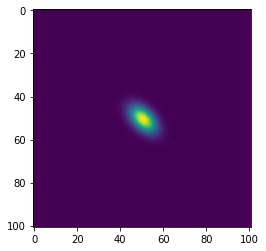

In [14]:
gauss = GaussianModel()

test = gauss.generate(params={"ELLIP": 0.4, "PA": np.pi/4})

plt.imshow(test[0])